In [57]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install scikit-learn --quiet
!{sys.executable} -m pip install torch --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
import torch
from torch.autograd import Variable
import torch.nn as nn

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')


colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

patient_idx = 3

dat = alldat[0, patient_idx]


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(3)


Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [59]:
# Define normalisation of voltage channels
# import notch filter
from scipy.signal import iirnotch, lfilter
from scipy.signal import butter, filtfilt

def notch_filter(data, fs, f0, Q):
    b, a = iirnotch(f0, Q, fs)
    filtered_data = lfilter(b, a, data)
    return filtered_data
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


xmax = max(dat['targetX'])
xmin = min(dat['targetX'])
ymax = max(dat['targetY'])
ymin = min(dat['targetY'])

def Vnormalise(_V):
    Vmax =  max((max(x) for x in _V))
    Vmin = min((min(x) for x in _V))
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

  
def downsample(signal, factor):
  nbins = math.floor(nt/factor)
  signal_norm = np.zeros((nbins, 1))
  for ibin in range(nbins):
    binstart = ibin * factor
    binend = binstart + factor
    signal_norm[ibin, 0] = np.mean(signal[binstart:binend])

  return signal_norm


In [60]:
ds = False #downsample data?
select_channels = False #Use correlated channels only?


# Load patient 
dat = alldat[0, patient_idx]
corr_chan = sorted([5, 23, 17, 1, 25])

V = dat['V']
V = Vnormalise(V)
if select_channels:
  V = V[:, corr_chan]
nt, nchan = V.shape
cx = Xnormalise(dat['targetX'].flatten()).reshape(-1,1)
cy = Ynormalise(dat['targetY'].flatten()).reshape(-1,1)

print('number of samples', nt, 'number of channels', nchan)
print('V shape', V.shape)
print('cx, cy shape', cx.shape, cy.shape)

factor = min(len(V), 40) #target trajectory updates every 40 samples, hardware limitation
if downsample:
  nbins = math.floor(nt/factor)

  V_norm = np.zeros((nbins, nchan))
  for c in range(nchan):
    V_norm[:,c] = downsample(V[:,c], factor).flatten()
  V = V_norm
  cx = downsample(cx, factor)
  cy = downsample(cy, factor)

  print("post normalisation:")
  print('number of samples', nt, 'number of channels', nchan)
  print('V shape', V.shape)
  print('cx, cy shape', cx.shape, cy.shape)



number of samples 259920 number of channels 48
V shape (259920, 48)
cx, cy shape (259920, 1) (259920, 1)
post normalisation:
number of samples 259920 number of channels 48
V shape (6498, 48)
cx, cy shape (6498, 1) (6498, 1)


# Investigated Downsampling
Downsampling in this dataset with correlated channels enabled casues noise in the loss graph which is not ideal.

In [61]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [62]:
def generate_tensors(X, y, tt_ratio=0.8, lookback=200, lookahead=25):
    X_ss, y_ss = split_sequences(X, y, lookback, lookahead)

    total_samples = len(X_ss)  # Should be len(X_ss) instead of len(X)
    train_test_cutoff = round(tt_ratio * total_samples)

    X_train = X_ss[:train_test_cutoff]
    X_test = X_ss[train_test_cutoff:]

    y_train = y_ss[:train_test_cutoff]
    y_test = y_ss[train_test_cutoff:] 

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   
                                          (X_train_tensors.shape[0], lookback, 
                                           X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  
                                         (X_test_tensors.shape[0], lookback, 
                                          X_test_tensors.shape[2])) 

    print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
    print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 
    print("Test/Train cutoff:", train_test_cutoff)
    print("Total data points:", total_samples)
    
    return X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors



In [63]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(output[:, -1, :])
        return out


In [64]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    test_losses = []
    train_losses = []
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        if epoch % 100 == 0 or (epoch < 50 and epoch % 10 == 0):
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
    return train_losses, test_losses

In [65]:
def extract_cartesian(signal):
  signal = np.array(signal)
  yi = int(signal.shape[1]/2)

  signal_extracted = signal[:, [0, yi]]
  x_traj = signal_extracted[:,0].tolist()
  y_traj = signal_extracted[:,1].tolist()

  return np.array([x_traj, y_traj])

  

# Define plotting functions
def predict(model, inputs, targetsX, targetsY, tt_ratio, test=False):

  # split the sequence
  X_ss, yX_ss = split_sequences(inputs, targetsX, lookback, lookahead)
  X_ss, yY_ss = split_sequences(inputs, targetsY, lookback, lookahead)

  # converting to tensors
  df_X_ss = Variable(torch.Tensor(X_ss))
  df_yX_mm = Variable(torch.Tensor(yX_ss))
  df_yY_mm = Variable(torch.Tensor(yY_ss))
  df_y_mm = torch.cat((df_yX_mm, df_yY_mm), dim=1)
  # reshaping the dataset
  df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], lookback, df_X_ss.shape[2]))

  train_predict = model(df_X_ss) # forward pass
  data_predict = train_predict.cpu().data.numpy() # numpy conversion
  data_plot = df_y_mm.cpu().data.numpy()

  data_predict_extracted = extract_cartesian(data_predict)
  print(data_predict_extracted)
  data_predictX, data_predictY = data_predict_extracted[0], data_predict_extracted[1]
  data_true_extracted = extract_cartesian(data_plot)
  data_trueX, data_trueY = data_true_extracted[0], data_true_extracted[1]




  trueX, trueY, predsX, predsY = [], [], [], []
  for i in range(len(data_predictX)):
      predsX.append(data_predictX[i])
  for i in range(len(data_predictY)):
      predsY.append(data_predictY[i])
  for i in range(len(data_trueX)):
      trueX.append(data_trueX[i])
  for i in range(len(data_trueY)):
      trueY.append(data_trueY[i])

  total_samples = len(trueX)
  train_test_cutoff = round(tt_ratio* total_samples)

  print("Predicted trajectory length:", len(trueX))
  if test:
    trueX = trueX[train_test_cutoff:]
    predsX = predsX[train_test_cutoff:]
    trueY = trueY[train_test_cutoff:]
    predsY = predsY[train_test_cutoff:]
    print("Predicted trajectory TEST length:", len(trueX))
  
  
  return trueX, trueY, predsX, predsY

def plot_prediction(true, preds, tt_ratio, xory: int = 0):
  
  """
  Plots the predicted and true values of a time series
  
  Args:
    true: list of true values
    preds: list of predicted values
    tt_ratio: float, proportion of training data
    xory: int, 0 for x, 1 for y
  """
  
  if xory not in [0, 1]:
    raise ValueError("xory must be 0 or 1")
  
  coor = "x" if xory == 0 else "y"
  
  total_samples = len(true)
  train_test_cutoff = round(tt_ratio* total_samples)

  plt.figure(figsize=(20,6)) #plotting
  plt.subplot(1, 2, 1)
  plt.plot(true, label='Actual Data') # actual plot
  plt.plot(preds, label='Predicted Data', color='#C44E52') # predicted plot
  plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
  plt.title('Time-Series Prediction')
  plt.legend()
  plt.xlabel("Sample n")
  plt.ylabel(f"{coor} coordinate (normalised)")

  plt.subplot(1, 2, 2)
  plt.xlim(left = train_test_cutoff - train_test_cutoff*0/1)
  plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
  plt.xlabel("Sample n")
  plt.ylabel(f"{coor} coordinate (normalised)")
  plt.plot(true[train_test_cutoff:], label='Actual Data') # actual plot
  plt.plot(preds[train_test_cutoff:], label='Predicted Data', color='#C44E52') # predicted plot
  plt.title('Time-Series Prediction (Test Set)')
  plt.show() 
  

  # print("test/train boundary:", train_test_cutoff)
  # print("test/train proportion:", train_test_cutoff/total_samples)
  # print("train length:", total_samples - train_test_cutoff)
  rms_test = rms(np.array(true), np.array(preds))
  print(rms_test)

  plt.suptitle('RMS: {}'.format(final_rms))

def plot_losses(train_loss, test_loss):
  plt.plot(train_loss, label="Train Losses")
  #plt.plot(test_loss, label="Test Losses")
  plt.legend
  plt.xlabel("Epoch")
  plt.ylabel("Training Loss")

def bin_trajectory(x, y, nbins):
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = traj_chunk.shape[1]
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
      
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory")
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory", color='#C44E52')
    plt.xlabel("Normalised x coordinate")
    plt.ylabel("Normalised y coordinate")


  plt.legend()


In [66]:
#Define common metric between models
def rms(truth, prediction):
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    return _rms

In [67]:
# run hyperopt option
run_hyperopt = False

In [68]:
!pip install hyperopt --quiet
from hyperopt import hp, fmin, tpe, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

def run_lstm_hyperopt(learning_rate, n_epochs, lstm_x, V, cx, cy, train_test_proportion, lookback, lookahead):
    # generate tensors for x model
    X_train_tensors_final, yX_train_tensors, X_test_tensors_final, yX_test_tensors = generate_tensors(V, cx, train_test_proportion, lookback, lookahead)
    _, yY_train_tensors, _, yY_test_tensors = generate_tensors(V, cy, train_test_proportion, lookback, lookahead)

    print("yX_train_tensors.shape:", yX_train_tensors.shape)
    print("yY_train_tensors.shape:", yY_train_tensors.shape)
    print("yX_test_tensors.shape:", yX_test_tensors.shape)
    print("yY_test_tensors.shape:", yY_test_tensors.shape)

    # Ensure the tensors have the same size along the concatenation dimension
    min_train_size = min(yX_train_tensors.size(0), yY_train_tensors.size(0))
    yX_train_tensors = yX_train_tensors[:min_train_size]
    yY_train_tensors = yY_train_tensors[:min_train_size]
    
    min_test_size = min(yX_test_tensors.size(0), yY_test_tensors.size(0))
    yX_test_tensors = yX_test_tensors[:min_test_size]
    yY_test_tensors = yY_test_tensors[:min_test_size]

    y_train_tensors = torch.cat((yX_train_tensors, yY_train_tensors), dim=1)
    y_test_tensors = torch.cat((yX_test_tensors, yY_test_tensors), dim=1)
    
    print("y_train_tensors.shape:", y_train_tensors.shape)
    print("y_test_tensors.shape:", y_test_tensors.shape)

    # define training methods
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(lstm_x.parameters(), lr=learning_rate) 

    # train model
    train_loss, test_loss = training_loop(n_epochs=n_epochs,
                    lstm=lstm_x,
                    optimiser=optimiser,
                    loss_fn=loss_fn,
                    X_train=X_train_tensors_final,
                    y_train=y_train_tensors,
                    X_test=X_test_tensors_final,
                    y_test=y_test_tensors)
    print("Final train loss:", train_loss[-1], "Final test loss:", test_loss[-1])
    # return one metric between train and test, weighted sum
    return 0.2*train_loss[-1] + 0.5*test_loss[-1]

# define search space
space = {
    'hidden_size': hp.choice('hidden_size', [10, 20, 30]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'n_epochs': scope.int(hp.quniform('n_epochs', 1000, 4000, 1000)),
    'lookback':hp.choice('lookback', [200, 400, 600, 800, 1000]),
    'lookahead': hp.choice('lookahead', [100, 200, 300, 400, 500]),
    'num_layers': hp.choice('num_layers', range(1, 3)),
    'V': V,
    'cx': cx,
    'cy': cy,
    'train_test_proportion': hp.choice('train_test_proportion', range(75, 90, 5))
}

def objective(params):
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']
    n_epochs = params['n_epochs']
    lookback = params['lookback']
    lookahead = params['lookahead']
    num_layers = params['num_layers']
    V = params['V']
    cx = params['cx']
    cy = params['cy']
    train_test_proportion = params['train_test_proportion'] / 100
    num_classes = lookahead * 2
    lstm_x = LSTM(num_classes,  
                    nchan, 
                    hidden_size, 
                    num_layers,
                    )
    print("Training model with params:", (hidden_size, learning_rate, n_epochs, lookback, lookahead, num_layers))
    lstm_loss = run_lstm_hyperopt(learning_rate, n_epochs, lstm_x, V, cx, cy, train_test_proportion, lookback, lookahead)
    # clear lstm_x object
    del lstm_x
    
    return lstm_loss


if run_hyperopt:
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)
    best_params = space_eval(space, best)
    print("Best params:", best_params)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
# current best params: 'learning_rate': 0.005318323827965791, 'n_epochs': 4000.0

In [70]:
# data preprocessing parameters
train_test_proportion = 0.85
lookback, lookahead = 600, 200 

In [71]:
# model architecture parameters
input_size = nchan # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 2 # number of stacked lstm layers

num_classes = lookahead * 2 # number of output classes 
# learning hyperparameters
import warnings
warnings.filterwarnings('ignore')

n_epochs =4000 # 2000 epochs
learning_rate = 0.0018997449990329892 # 0.005 lr

In [72]:
run_training = True

In [73]:

lstm_x = LSTM(num_classes,  
                input_size, 
                hidden_size, 
                num_layers,
                )

def run_lstm(learning_rate, n_epochs, lstm_x, V, cx, cy, train_test_proportion, lookback, lookahead):
    # generate tensors for x model
    X_train_tensors_final, yX_train_tensors, X_test_tensors_final, yX_test_tensors = generate_tensors(V, cx, train_test_proportion, lookback, lookahead)
    X_train_tensors_final, yY_train_tensors, X_test_tensors_final, yY_test_tensors = generate_tensors(V, cy, train_test_proportion, lookback, lookahead)

    print(yX_train_tensors.shape)
    y_train_tensors = torch.cat((yX_train_tensors, yY_train_tensors), dim=1)
    y_test_tensors = torch.cat((yX_test_tensors, yY_test_tensors), dim=1)
    print(y_train_tensors.shape)
    # define training methods
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(lstm_x.parameters(), lr=learning_rate) 

    # train model
    train_loss, test_loss = training_loop(n_epochs=n_epochs,
                    lstm=lstm_x,
                    optimiser=optimiser,
                    loss_fn=loss_fn,
                    X_train=X_train_tensors_final,
                    y_train=y_train_tensors,
                    X_test=X_test_tensors_final,
                    y_test=y_test_tensors)
    
    print("Final train loss:", train_loss[-1], "Final test loss:", test_loss[-1])

    return train_loss, test_loss

if run_training:
    train_loss, test_loss = run_lstm(learning_rate, n_epochs, lstm_x, V, cx, cy, train_test_proportion, lookback, lookahead)

    # save model
    torch.save(lstm_x.state_dict(), f'lstm_x_p{patient_idx}.pth')
else:
    lstm_x.load_state_dict(torch.load(f'lstm_x_p{patient_idx}.pth'))
    lstm_x.eval()
    print("Model loaded")

Training Shape: torch.Size([4845, 600, 48]) torch.Size([4845, 200])
Testing Shape: torch.Size([855, 600, 48]) torch.Size([855, 200])
Test/Train cutoff: 4845
Total data points: 5700
Training Shape: torch.Size([4845, 600, 48]) torch.Size([4845, 200])
Testing Shape: torch.Size([855, 600, 48]) torch.Size([855, 200])
Test/Train cutoff: 4845
Total data points: 5700
torch.Size([4845, 200])
torch.Size([4845, 400])
Epoch: 0, train loss: 0.41160, test loss: 0.41296
Epoch: 10, train loss: 0.36243, test loss: 0.36403
Epoch: 20, train loss: 0.30548, test loss: 0.30314
Epoch: 30, train loss: 0.23819, test loss: 0.23453
Epoch: 40, train loss: 0.18093, test loss: 0.17729
Epoch: 100, train loss: 0.10698, test loss: 0.10669
Epoch: 200, train loss: 0.10622, test loss: 0.10630
Epoch: 300, train loss: 0.10609, test loss: 0.10628
Epoch: 400, train loss: 0.10588, test loss: 0.10615
Epoch: 500, train loss: 0.09880, test loss: 0.10165
Epoch: 600, train loss: 0.06351, test loss: 0.06648
Epoch: 700, train loss: 

In [74]:
# generate final prediction
true_x, true_y, preds_x, preds_y = predict(lstm_x, V, cx, cy, train_test_proportion)

print(preds_x)
print(preds_y)

[[0.27201325 0.2891618  0.3070361  ... 0.39464435 0.37693292 0.36018172]
 [0.33555651 0.31725812 0.2991848  ... 0.96591264 0.95909745 0.95169616]]
Predicted trajectory length: 5700
[0.27201324701309204, 0.2891618013381958, 0.3070361018180847, 0.3260507583618164, 0.345318466424942, 0.36453500390052795, 0.3840959072113037, 0.40497374534606934, 0.4268786609172821, 0.44918856024742126, 0.4704478681087494, 0.49072906374931335, 0.5105549097061157, 0.530053973197937, 0.5493219494819641, 0.567894458770752, 0.5863285660743713, 0.6045123934745789, 0.6231561303138733, 0.6410551071166992, 0.6586682200431824, 0.6757442951202393, 0.692323625087738, 0.708591103553772, 0.7242528796195984, 0.7396318316459656, 0.7544483542442322, 0.7687091827392578, 0.7821033000946045, 0.7951463460922241, 0.8074895739555359, 0.8194146156311035, 0.8307684659957886, 0.8415601253509521, 0.8519664406776428, 0.8618471622467041, 0.8712440133094788, 0.8805280923843384, 0.8896305561065674, 0.8982788920402527, 0.906469464302063,

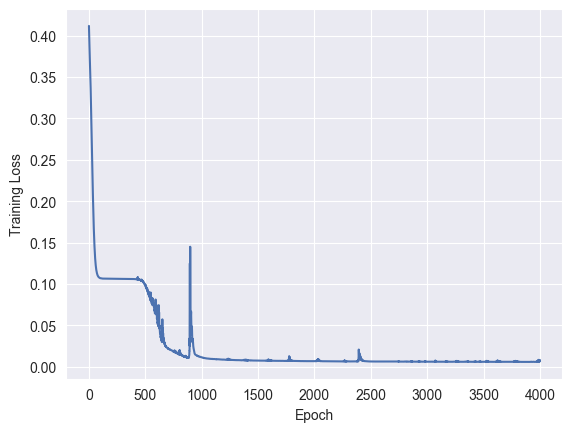

In [75]:
if run_training:
    plot_losses(train_loss, test_loss)


[[0.27201325 0.2891618  0.3070361  ... 0.39464435 0.37693292 0.36018172]
 [0.33555651 0.31725812 0.2991848  ... 0.96591264 0.95909745 0.95169616]]
Predicted trajectory length: 5700
Predicted trajectory TEST length: 855
42
Final rms:  0.09396498479080244


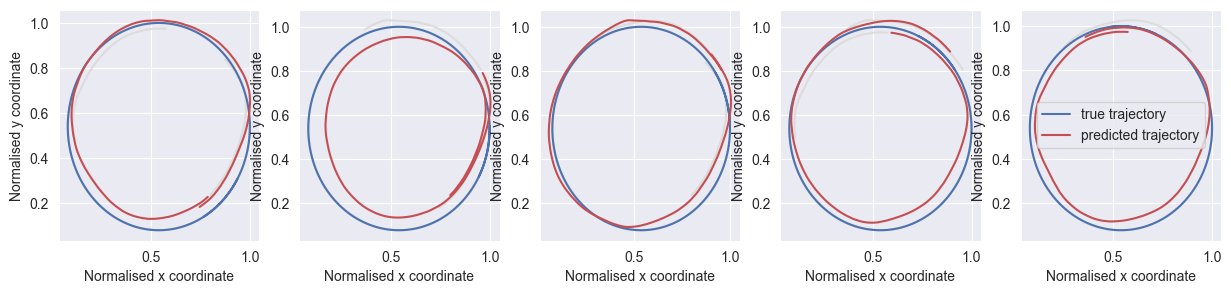

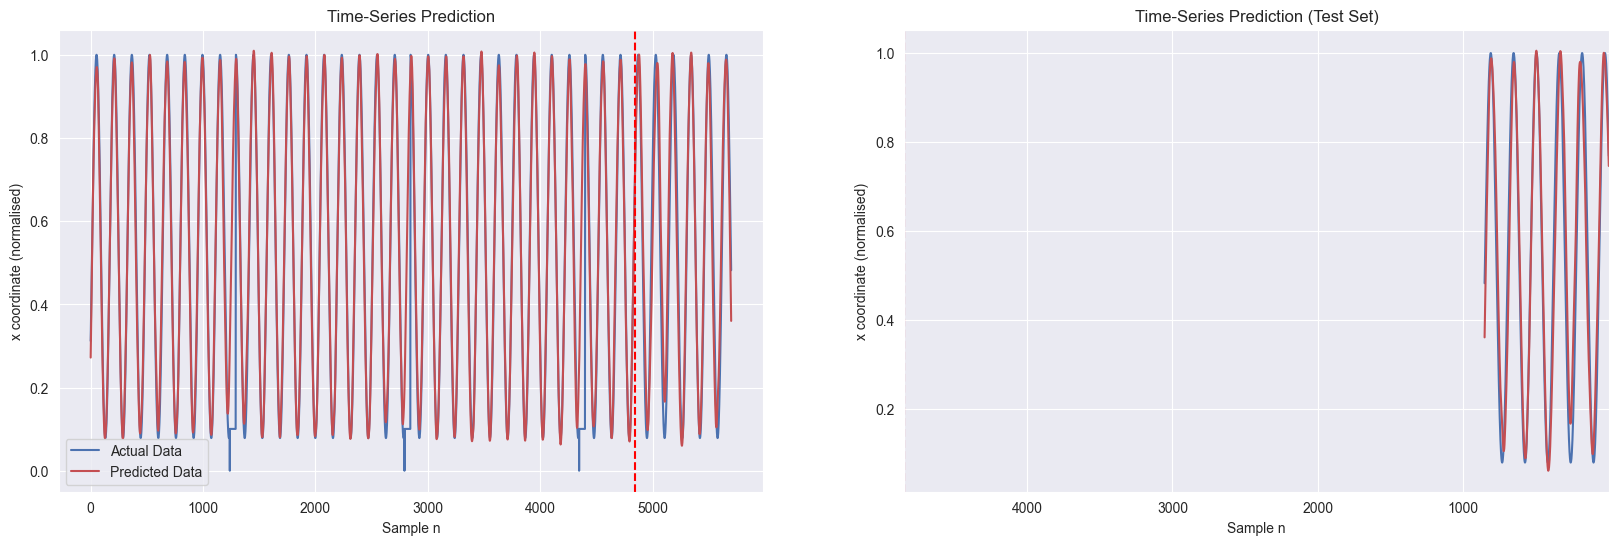

0.1091076876849734


<Figure size 640x480 with 0 Axes>

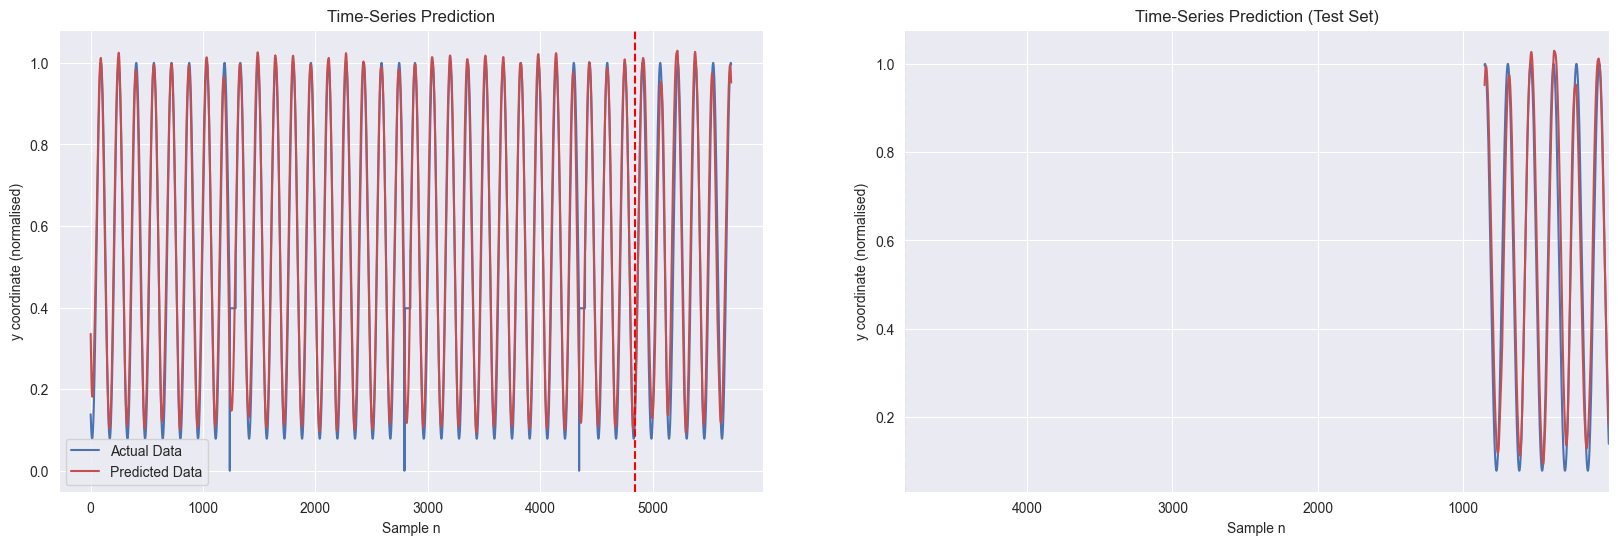

0.06534945029388024
Final rms:  0.09396498479080244


<Figure size 640x480 with 0 Axes>

In [76]:

true_x_test, true_y_test, preds_x_test, preds_y_test = predict(lstm_x, V, cx, cy, train_test_proportion, test=True)
plot_trajectories(true_x_test, true_y_test, preds_x_test, preds_y_test, nbins=5, shadow=True)



traj_preds = [preds_x_test, preds_y_test]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [true_x_test, true_y_test]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("Final rms: ", final_rms)




plot_prediction(true_x, preds_x, train_test_proportion, xory=0)
plot_prediction(true_y, preds_y, train_test_proportion, xory=1)


traj_preds = [preds_x_test, preds_y_test]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [true_x_test, true_y_test]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("Final rms: ", final_rms)



